In [1]:
# Retrieve image files
import glob
import cv2
import numpy as np
# Divide up into cars and notcars
images = glob.glob('*_smallset/*/*.jpeg')
print(len(images))
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

2321


In [2]:
# sample_car = cv2.cvtColor(cv2.imread(cars[10]), cv2.COLOR_BGR2RGB)
sample_notcar = cv2.cvtColor(cv2.imread(notcars[10]), cv2.COLOR_BGR2RGB) / 255
print(np.min(sample_notcar), " ", np.max(sample_notcar))

0.250980392157   1.0


In [3]:
# Files for the example output
fout = 'examples/car_not_car.png'
hog_out = 'examples/HOG_example.jpg'
labels_map = 'examples/labels_map.png'
sliding_window = 'examples/sliding_window.jpg'
sliding_windows = 'examples/sliding_windows.jpg'
bboxes_and_heat = 'examples/bboxes_and_heat.png'

def plot_together(car, notcar):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(car)
    plt.title("Car")
    plt.subplot(1,2,2)
    plt.imshow(notcar)
    plt.title("Not Car")
    plt.savefig(fout)

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lesson_functions import get_hog_features

sample_index = np.random.randint(len(cars))
sample_car = cv2.imread(cars[sample_index])
sample_car = cv2.cvtColor(sample_car, cv2.COLOR_BGR2RGB)
sample_index = np.random.randint(len(notcars))
sample_notcar = cv2.imread(notcars[sample_index])
sample_notcar = cv2.cvtColor(sample_notcar, cv2.COLOR_BGR2RGB)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        hog_img = []
        for channel in range(feature_image.shape[2]):
            hog_feature, hog_c = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True, tsqrt=True)
            hog_features.append(hog_feature)
            hog_img.append(hog_c)
        hog_features = np.ravel(hog_features)        
    else:
        hog_features, hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True, tsqrt=True)
        
    # Return list of feature vectors
    return hog_features, hog_img

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
_, sample_car_hog = extract_features(sample_car, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
_, sample_notcar_hog = extract_features(sample_notcar, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

def plot(sample, hog, savefig=False):
    plt.figure()
    plt.imshow(sample)
    plt.figure()
    if hog_channel == "ALL":
        for i in range(3):
            plt.subplot(1,3,i+1)
            plt.imshow(hog[i])
    else:
        plt.imshow(hog)
    if savefig:
        plt.savefig(hog_out)
    
plot(sample_car, sample_car_hog, savefig=True)
plot(sample_notcar, sample_notcar_hog)

plot_together(sample_car, sample_notcar)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
from lesson_functions import *
from pipeline import find_cars
from time import time

# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle_Y.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
cspace = dist_pickle["colorspace"]
hog_channel = dist_pickle["hog_channel"]

ystart = 400 - 20
ystop = [528 - 20, 656 - 20]
scale = [1.0, 1.5]

bbox_lists = []
images = []
for i in range(6):
    img = mpimg.imread('frames/frame%d.png' % (i+1))
    images.append(img)
    bboxes_out = list()
    for j in range(len(scale)):
        bboxes = find_cars(img, ystart, ystop[j], scale[j], svc, X_scaler, orient, pix_per_cell, cell_per_block, cspace, hog_channel) #, spatial_size, hist_bins)
        bboxes_out += bboxes
    bbox_lists.append(bboxes_out)


In [ ]:
from pipeline import add_heat, apply_threshold, draw_labeled_bboxes
from scipy.ndimage.measurements import label
from time import time

for i in range(6):
    t = time()
    image = images[i]
    bbox_list = bbox_lists[i]
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float32)
    heat = add_heat(heat,bbox_list)
    initial_labels = label(heat)

    # Apply threshold to help remove false positives
    heat_thresholded = apply_threshold(heat, 4, initial_labels) 

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_thresholded, 0, 255)
    heatmap[heatmap < 2] = 0
    labels = label(heatmap)

    # Find final boxes from heatmap using label function
    draw_img = np.copy(img)
    for bbox in bbox_list:
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,1), 6)
    
    t2 = time()
    plt.subplot(6,2,2*i+1)
    plt.imshow(draw_img)
    plt.subplot(6,2,2*i+2)
    plt.imshow(heat, cmap='hot')

In [ ]:
from pipeline import add_heat, apply_threshold, draw_labeled_bboxes
from scipy.ndimage.measurements import label
from time import time

heat = np.zeros_like(image[:,:,0]).astype(np.float32)

for i in range(6):
    t = time()
    image = images[i]
    bbox_list = bbox_lists[i]
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
# Create the initial labels
initial_labels = label(heat)

# Apply threshold to help remove false positives
heat_thresholded = apply_threshold(heat, 15, initial_labels) 

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_thresholded, 0, 255)
heatmap[heatmap < 6] = 0
labels = label(heatmap)

# Find final boxes from heatmap using label function
#     draw_img = np.copy(img)
t2 = time()
print("Time taken:", (t2-t))
plt.figure()
draw_img = heatmap
plt.imshow(labels[0])
plt.figure()
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


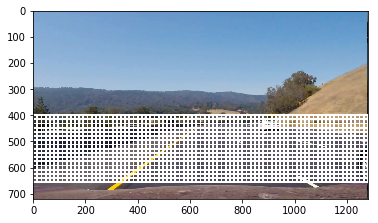

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
from lesson_functions import *
from pipeline import find_cars
from time import time
from pipeline import create_windows

# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle_Y.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]
cspace = dist_pickle["colorspace"]
hog_channel = dist_pickle["hog_channel"]

ystart = 400
ystop = [656]
scale = [1.0]

bbox_lists = []
images = []
img = mpimg.imread('corner-case2.png')
images.append(img)
bboxes_out = list()
for j in range(len(scale)):
    bboxes = create_windows(img, ystart, ystop[j], scale[j], orient, pix_per_cell, cell_per_block, cspace, hog_channel) #, spatial_size, hist_bins)
    bboxes_out += bboxes
bbox_lists.append(bboxes_out)

i=0
draw_img = np.copy(img)
for bbox in bboxes_out:
    cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,255), 6)
    i+=1
plt.imshow(draw_img)

Time taken: 0.055973052978515625


IndexError: list index out of range

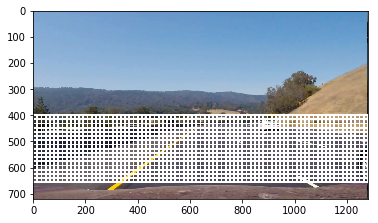

In [3]:
from pipeline import add_heat, apply_threshold, draw_labeled_bboxes
from scipy.ndimage.measurements import label
from time import time

for i in range(6):
    t = time()
    image = images[i]
    bbox_list = bbox_lists[i]
    
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float32)
    heat = add_heat(heat,bbox_list)
    initial_labels = label(heat)

    # Find final boxes from heatmap using label function
    draw_img = np.copy(img)
    for bbox in bbox_list:
        cv2.rectangle(draw_img, bbox[0], bbox[1], (0,0,1), 6)
    
    t2 = time()
    
    print("Time taken:", (t2-t))
    plt.figure()
    plt.imshow(draw_img)

1.0 0.0


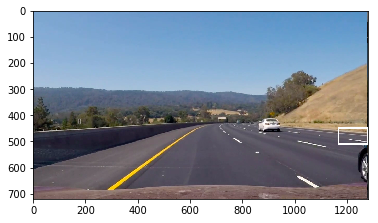

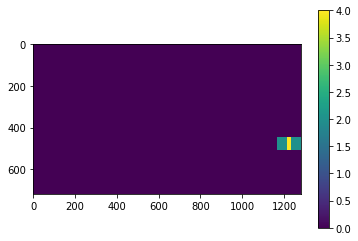

In [2]:
# Single image analysis

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
from lesson_functions import *
from pipeline import find_cars, add_heat, apply_threshold, draw_labeled_bboxes, pipeline
from time import time
from scipy.ndimage.measurements import label
import warnings


# load a pe-trained svc model from a serialized (pickle) file
dist_pickle = pickle.load( open("svc_pickle_Y_big.p", "rb" ) )

# get attributes of our svc object
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]
cspace = dist_pickle["colorspace"]
hog_channel = dist_pickle["hog_channel"]

bbox_lists = []
images = []
img = mpimg.imread('corner-case2.png')

print(np.max(img), np.min(img))
draw_img, heatmap = pipeline(img, dist_pickle, add_heatmap=True)
plt.figure()
plt.imshow(draw_img)
plt.figure()
plt.imshow(heatmap)
plt.colorbar()
# plt.figure()
# plt.imshow(heat / np.maximum(np.max(heat), 1))


In [3]:
from pipeline import extract_features

imgs = ['corner-cases/corner-case-carb.png', 'corner-cases/corner-case-car2b.png', "corner-cases/car_side.png",
       'corner-cases/screen_capture_256_r64.png', "vehicles/GTI_Far/image0312.png","vehicles/GTI_Far/image0925.png",
        "vehicles/GTI_Far/image0313.png", "vehicles/GTI_Far/image0648.png",]
for item in dist_pickle:
    print(item, dist_pickle[item])
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
features = extract_features(imgs, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


for i in range(len(imgs)):
    # Scale features and make a prediction
    test_features = X_scaler.transform(features[i].reshape((1, -1)))    
    test_prediction = svc.decision_function(test_features)
    print(imgs[i], test_prediction)

svc GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 1.0, 10.0], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
orient 9
scaler StandardScaler(copy=True, with_mean=True, with_std=True)
cell_per_block 2
pix_per_cell 8
hog_channel ALL
colorspace YCrCb
corner-cases/corner-case-carb.png [-0.92075737]
corner-cases/corner-case-car2b.png [ 0.35014099]
corner-cases/car_side.png [ 0.24192878]
corner-cases/screen_capture_256_r64.png [-0.35692059]
vehicles/GTI_Far/image0312.png [ 1.00040247]
vehicles/GTI_Far/image0925.png [ 0.26724955]
vehicles/GTI_Far/image0313.png [ 0.66987582]
vehicles/GTI_Far/image0648

In [4]:
from pipeline import extract_features

imgs = ['corner-cases/corner-case-carb.png', 'corner-cases/corner-case-car2b.png', "corner-cases/corner-case-road.png",
       'corner-cases/screen_capture_256_r64_gb.png', "vehicles/GTI_Far/image0312.png","vehicles/GTI_Far/image0925.png",
        "vehicles/GTI_Far/image0313.png", "vehicles/GTI_Far/image0648.png",]
for item in dist_pickle:
    print(item, dist_pickle[item])
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
features = extract_features(imgs, cspace=cspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


for i in range(len(imgs)):
    # Scale features and make a prediction
    test_features = X_scaler.transform(features[i].reshape((1, -1)))    
    test_prediction = svc.decision_function(test_features)
    print(imgs[i], test_prediction)

svc GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 1.0, 10.0], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
orient 9
scaler StandardScaler(copy=True, with_mean=True, with_std=True)
cell_per_block 2
pix_per_cell 8
hog_channel ALL
colorspace YCrCb
corner-cases/corner-case-carb.png [-0.92075737]
corner-cases/corner-case-car2b.png [ 0.35014099]
corner-cases/corner-case-road.png [-1.07486966]
corner-cases/screen_capture_256_r64_gb.png [-1.44907385]
vehicles/GTI_Far/image0312.png [ 1.00040247]
vehicles/GTI_Far/image0925.png [ 0.26724955]
vehicles/GTI_Far/image0313.png [ 0.66987582]
vehicles/GTI_Fa